In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

In [2]:
data = pd.read_csv('./housing.csv') 

print(data.columns)

Index(['Title', 'Address', 'City', 'Price', 'Bedroom', 'Bathroom', 'Floors',
       'Parking', 'Face', 'Year', 'Views', 'Area', 'Road', 'Road Width',
       'Road Type', 'Build Area', 'Posted', 'Amenities'],
      dtype='object')


In [3]:
print(data.isna().sum())

Title            0
Address          0
City             0
Price            0
Bedroom          0
Bathroom         0
Floors        1172
Parking          0
Face             0
Year          1629
Views            0
Area             0
Road             0
Road Width       0
Road Type      785
Build Area       0
Posted           0
Amenities        0
dtype: int64


In [4]:
print(data['Road Width'].head(60))

0     20 Feet 
1     20 Feet 
2     20 Feet 
3     20 Feet 
4     20 Feet 
5     13 Feet 
6     11 Feet 
7     20 Feet 
8     20 Feet 
9     12 Feet 
10    15 Feet 
11    14 Feet 
12    12 Feet 
13    20 Feet 
14    13 Feet 
15    13 Feet 
16    20 Feet 
17     13 Feet
18      0 Feet
19     10 Feet
20    10 Feet 
21    20 Feet 
22    20 Feet 
23    20 Feet 
24    13 Feet 
25     32 Feet
26    13 Feet 
27    13 Feet 
28    16 Feet 
29    13 Feet 
30    13 Feet 
31     13 Feet
32    15 Feet 
33    15 Feet 
34    15 Feet 
35    16 Feet 
36    15 Feet 
37    14 Feet 
38    20 Feet 
39    18 Feet 
40    15 Feet 
41     15 Feet
42    13 Feet 
43    15 Feet 
44    14 Feet 
45    13 Feet 
46    13 Feet 
47    13 Feet 
48    13 Feet 
49    26 Feet 
50    14 Feet 
51    13 Feet 
52    15 Feet 
53    13 Feet 
54     13 Feet
55    20 Feet 
56    6 Meter 
57     29 Feet
58      0 Feet
59      0 Feet
Name: Road Width, dtype: object


In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2211 entries, 0 to 2210
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Title       2211 non-null   object 
 1   Address     2211 non-null   object 
 2   City        2211 non-null   object 
 3   Price       2211 non-null   int64  
 4   Bedroom     2211 non-null   int64  
 5   Bathroom    2211 non-null   int64  
 6   Floors      1039 non-null   float64
 7   Parking     2211 non-null   int64  
 8   Face        2211 non-null   object 
 9   Year        582 non-null    float64
 10  Views       2211 non-null   object 
 11  Area        2211 non-null   object 
 12  Road        2211 non-null   object 
 13  Road Width  2211 non-null   object 
 14  Road Type   1426 non-null   object 
 15  Build Area  2211 non-null   object 
 16  Posted      2211 non-null   object 
 17  Amenities   2211 non-null   object 
dtypes: float64(2), int64(4), object(12)
memory usage: 311.1+ KB
None


In [6]:
data['New Year'] = data['Year'].fillna(0).astype('int')

assert data['New Year'].dtype == 'int'


<Axes: >

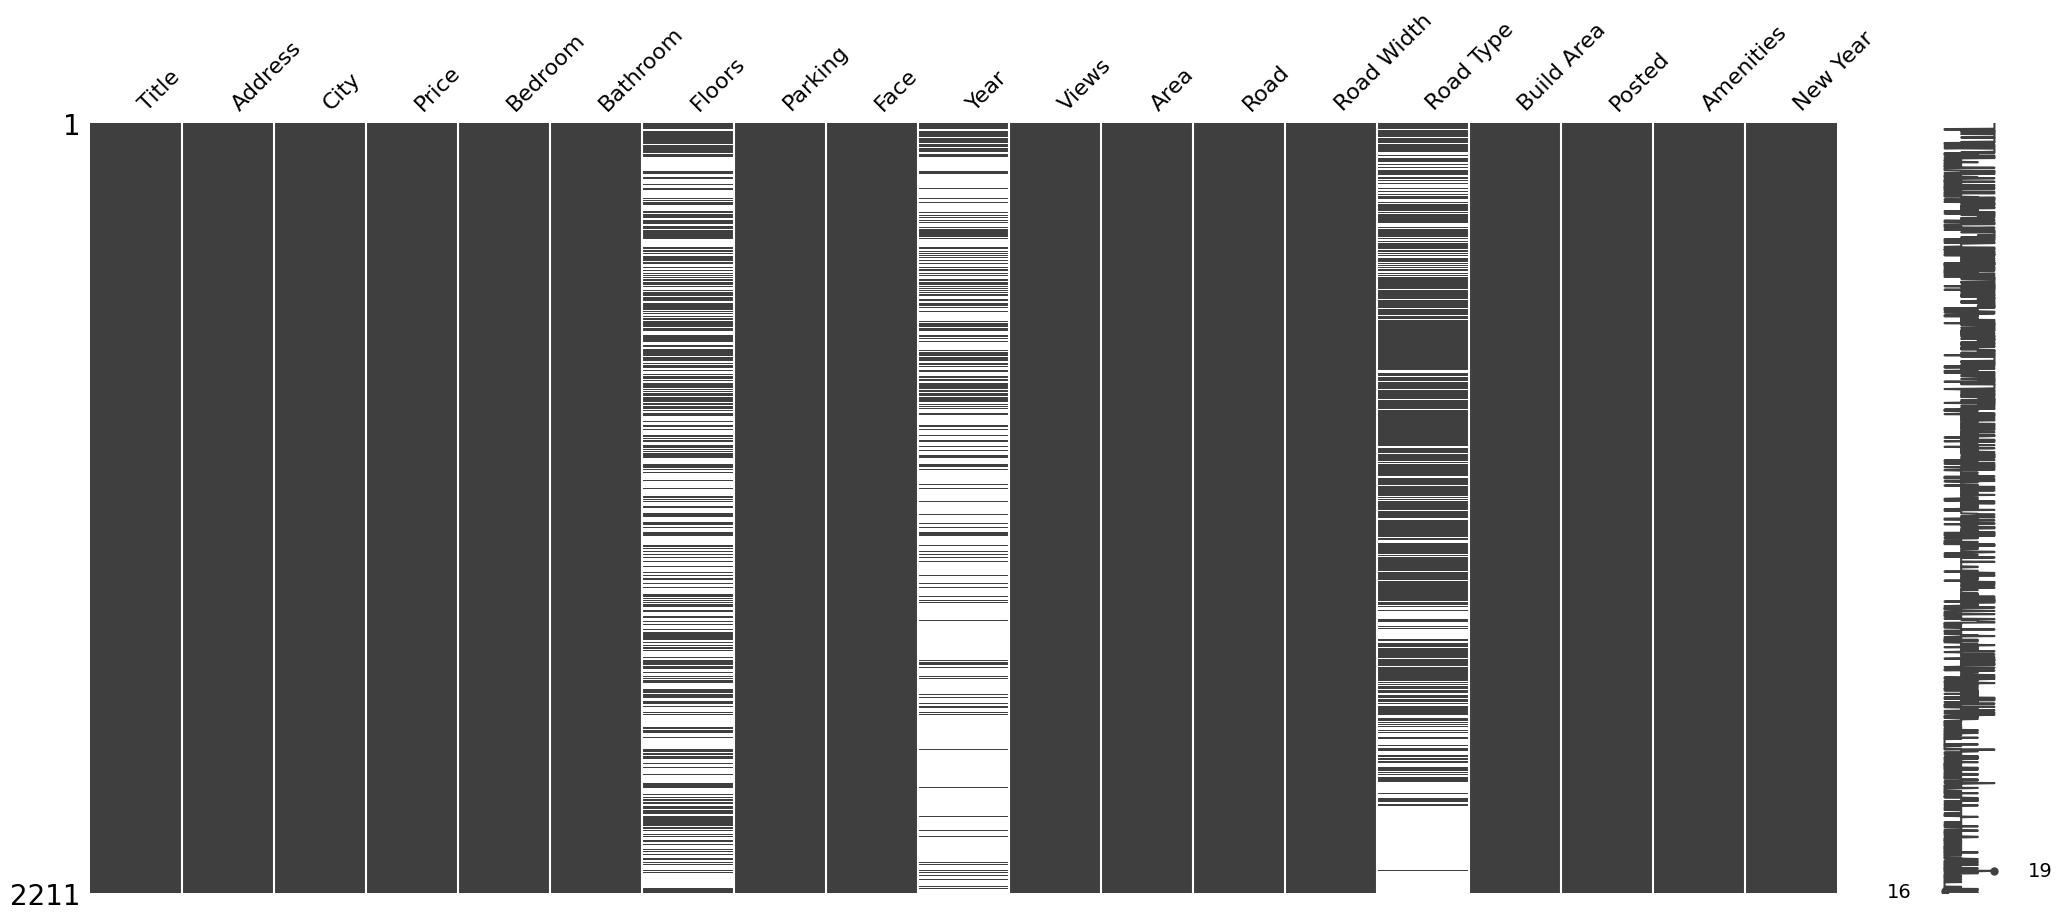

In [7]:
msno.matrix(data)

In [8]:
print(data['Views'])

0          17
1          26
2         154
3          17
4          59
        ...  
2206     3.1K
2207     1.4K
2208     1.5K
2209     2.5K
2210    19.6K
Name: Views, Length: 2211, dtype: object


In [10]:
def sen_changer(value):
    if 'K' in value:
        return int(float(value.replace('K', '')) * 1000)
    return value

data['New Views'] = data['Views'].apply(sen_changer)

In [11]:

data['New Views'] = data['New Views'].astype('int')


In [12]:
def feet_converter(value):
    if 'Feet' in value:
        return float(value.replace(' Feet', '').strip())
    elif 'Meter' in value:
        return float(value.replace(' Meter', '').strip())
    else:
        return float(value.strip())

data['New Width'] = data['Road Width'].apply(feet_converter)

assert data['New Width'].dtype == 'float'


In [13]:
print(data['New Width'])
print(data['New Year'])
print(data['New Views'])

0       20.0
1       20.0
2       20.0
3       20.0
4       20.0
        ... 
2206    16.0
2207    13.0
2208    12.0
2209    13.0
2210    12.0
Name: New Width, Length: 2211, dtype: float64
0       2073
1       2073
2       2071
3       2017
4       2070
        ... 
2206       0
2207       0
2208    2071
2209       0
2210       0
Name: New Year, Length: 2211, dtype: int64
0          17
1          26
2         154
3          17
4          59
        ...  
2206     3100
2207     1400
2208     1500
2209     2500
2210    19600
Name: New Views, Length: 2211, dtype: int64


In [14]:
price_q1 = np.quantile(data['Price'], 0.25)
price_q3 = np.quantile(data['Price'], 0.75)
iqr = price_q3 - price_q1
print(data['Price'])


0        90000000
1        80000000
2        70000000
3       130000000
4       100000000
          ...    
2206       500000
2207     12000000
2208     27000000
2209       300000
2210     72500000
Name: Price, Length: 2211, dtype: int64


In [15]:
price_upper_bound = price_q3 + 1.5 * iqr

data.loc[data['Price'] > price_upper_bound, 'Price'] = price_upper_bound

print(data['Price'])

0       64300000
1       64300000
2       64300000
3       64300000
4       64300000
          ...   
2206      500000
2207    12000000
2208    27000000
2209      300000
2210    64300000
Name: Price, Length: 2211, dtype: int64


In [16]:
data.loc[data['Price'] < price_q1, 'Price'] = price_q1
print(data['Price'])

0       64300000
1       64300000
2       64300000
3       64300000
4       64300000
          ...   
2206     1300000
2207    12000000
2208    27000000
2209     1300000
2210    64300000
Name: Price, Length: 2211, dtype: int64


In [17]:
print(data['Price'].mean())

17138917.68385346


In [19]:
bedroom_q1 = np.quantile(data['Bedroom'], 0.25)
bedroom_q3 = np.quantile(data['Bedroom'], 0.75)
bedroom_iqr = bedroom_q3 - bedroom_q1

print(bedroom_q1)
print(bedroom_q3)

0.0
5.0


In [20]:
bedroom_upper_bound = int(bedroom_q3 + 1.5 * bedroom_iqr)
print(bedroom_upper_bound)

12


In [21]:
data.loc[data['Bedroom'] > bedroom_upper_bound, 'Bedroom'] = bedroom_upper_bound

data.loc[data['Bedroom'] == 0, 'Bedroom'] = 1

print(data['Bedroom'].value_counts())

Bedroom
1     1132
5      246
4      224
6      161
3      118
2      110
7       68
12      48
8       35
10      29
9       20
11      20
Name: count, dtype: int64


In [22]:
bathroom_q1 = np.quantile(data['Bathroom'], 0.25)
bathroom_q3 = np.quantile(data['Bathroom'], 0.75)

bathroom_iqr = bathroom_q3 - bathroom_q1

print(bathroom_iqr)

4.0


In [23]:
upper_bathroom = bathroom_q3 + 1.5 * bathroom_iqr

data.loc[data['Bathroom'] > upper_bathroom, 'Bathroom'] = upper_bathroom

data.loc[(data['Bathroom'] == 0) & (data['New Year'] <= 2055), 'Bathroom'] = bathroom_q3

data.loc[(data['Bathroom'] == 0) & (data['New Year'] <= 2055) & (data['New Year'] >= 2065), 'Bathroom'] = 2

data.loc[(data['Bathroom'] == 0), 'Bathroom'] = 1

In [24]:
parking_q1 = np.quantile(data['Parking'], 0.25)
parking_q3 = np.quantile(data['Parking'], 0.75)

parking_iqr = parking_q3 - parking_q1


In [25]:
upper_parking = int(parking_q3 + 1.5 * parking_iqr)

data.loc[data['Parking'] > upper_parking, 'Parking'] = upper_parking

print(data['Parking'].value_counts())

Parking
0    1322
2     489
1     400
Name: count, dtype: int64


In [26]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2211 entries, 0 to 2210
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Title       2211 non-null   object 
 1   Address     2211 non-null   object 
 2   City        2211 non-null   object 
 3   Price       2211 non-null   int64  
 4   Bedroom     2211 non-null   int64  
 5   Bathroom    2211 non-null   int64  
 6   Floors      1039 non-null   float64
 7   Parking     2211 non-null   int64  
 8   Face        2211 non-null   object 
 9   Year        582 non-null    float64
 10  Views       2211 non-null   object 
 11  Area        2211 non-null   object 
 12  Road        2211 non-null   object 
 13  Road Width  2211 non-null   object 
 14  Road Type   1426 non-null   object 
 15  Build Area  2211 non-null   object 
 16  Posted      2211 non-null   object 
 17  Amenities   2211 non-null   object 
 18  New Year    2211 non-null   int64  
 19  New Views   2211 non-null  

In [27]:
print(data['City'].value_counts())

City
Kathmandu      1483
Lalitpur        432
Bhaktapur        85
Pokhara          64
Chitwan          33
Makwanpur        12
Nawalparasi      12
Dharan           11
Jhapa            10
Kavre             7
Kirtipur          7
Sunsari           7
Butwal            6
Biratnagar        6
Parsa             4
Bara              4
Dhading           4
Morang            4
Itahari           3
Kaski             3
Rupandehi         3
Birtamod          1
Nawalpur          1
Mahottari         1
Dang              1
Bardiya           1
Bhairahawa        1
Surkhet           1
Kapilvastu        1
Tanahu            1
Illam             1
Kailali           1
Name: count, dtype: int64


In [28]:
conditions = [(data['New Year'] >= 2065) & (data['Price'] < 10000000), (data['New Year'] >= 2065) & (data['Price'] >= 10000000) & (data['Price'] <= 30000000), (data['New Year'] >= 2065) & (data['Price'] > 30000000), (data['New Year'] < 2065) & (data['Price'] < 1500000), (data['New Year'] < 2065) & (data['Price'] >= 1500000)]
choices = ['Low', 'Medium', 'High', 'Medium', 'High']

data['Price Category'] = np.select(conditions, choices, default = 'Unkown')

print(data.loc[:, ['Price', 'Year', 'Price Category']].head(50))

       Price    Year Price Category
0   64300000  2073.0           High
1   64300000  2073.0           High
2   64300000  2071.0           High
3   64300000  2017.0           High
4   64300000  2070.0           High
5   64300000  2074.0           High
6   11000000  2019.0           High
7   50000000  2073.0           High
8   64300000  2017.0           High
9   32500000  2065.0           High
10  32000000  2075.0           High
11  39900000  2075.0           High
12  15000000  2074.0         Medium
13  52500000  2075.0           High
14  26500000  2076.0         Medium
15  25500000  2076.0         Medium
16  33000000  2056.0           High
17  18500000     NaN           High
18  62000000     NaN           High
19  10500000     NaN           High
20  20500000  2076.0         Medium
21  22000000     NaN           High
22  64300000  2073.0           High
23  55000000  2071.0           High
24  24000000  2075.0         Medium
25  37000000     NaN           High
26  64300000  2070.0        

Price Category
High      1426
Medium     756
Low         29
Name: count, dtype: int64


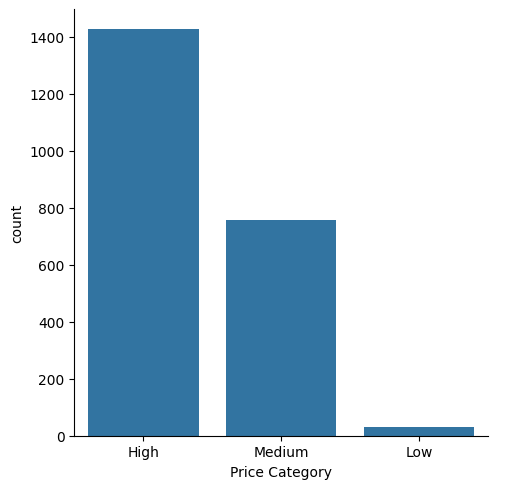

In [29]:
print(data['Price Category'].value_counts())
sns.catplot(kind='count', x = 'Price Category', data = data)

In [30]:
print(data['Floors'].isna().sum())
print(data['Floors'].value_counts(dropna=False))

1172
Floors
NaN      1172
3.00      562
2.00      166
4.00       84
1.00       58
2.50       54
0.00       38
5.00       25
1.50       14
3.50       10
6.00        8
7.00        5
10.00       4
4.50        3
12.00       2
9.00        2
13.00       1
1.35        1
5.50        1
8.00        1
Name: count, dtype: int64


In [31]:
missing_floor = data[data['Floors'].isna()]
complete_floor = data[~data['Floors'].isna()]

In [32]:
missing_floor.describe()

,Price,Bedroom,Bathroom,Floors,Parking,Year,New Year,New Views,New Width
count,1.172000e+03,1172.000000,1172.000000,0.0,1172.000000,49.000000,1172.000000,1172.000000,1172.000000
mean,9.551681e+06,1.818259,3.858362,NaN,0.220990,2045.408163,85.516212,629.557167,16.518345
std,1.521631e+07,2.048575,0.889491,NaN,0.572471,29.075991,409.609957,1299.586890,31.033237
min,1.300000e+06,1.000000,1.000000,NaN,0.000000,2002.000000,0.000000,23.000000,0.000000
25%,1.300000e+06,1.000000,4.000000,NaN,0.000000,2018.000000,0.000000,259.000000,12.000000
50%,2.600000e+06,1.000000,4.000000,NaN,0.000000,2065.000000,0.000000,371.000000,14.000000
75%,8.500000e+06,1.000000,4.000000,NaN,0.000000,2074.000000,0.000000,556.500000,20.000000
max,6.430000e+07,12.000000,10.000000,NaN,2.000000,2076.000000,2076.000000,24700.000000,500.000000


In [33]:
complete_floor.describe()

,Price,Bedroom,Bathroom,Floors,Parking,Year,New Year,New Views,New Width
count,1.039000e+03,1039.000000,1039.000000,1039.000000,1039.000000,533.000000,1039.000000,1039.000000,1039.000000
mean,2.569738e+07,4.512993,3.840231,2.824206,1.076997,2058.917448,1056.210780,1220.851781,15.242541
std,1.963685e+07,2.712558,1.646939,1.265411,0.826955,25.538205,1029.768983,2794.173546,7.772220
min,1.300000e+06,1.000000,1.000000,0.000000,0.000000,1994.000000,0.000000,17.000000,0.000000
25%,1.145000e+07,2.000000,3.000000,2.000000,0.000000,2045.000000,0.000000,300.000000,13.000000
50%,2.250000e+07,5.000000,4.000000,3.000000,1.000000,2074.000000,2007.000000,466.000000,14.000000
75%,3.700000e+07,6.000000,5.000000,3.000000,2.000000,2076.000000,2074.000000,835.000000,20.000000
max,6.430000e+07,12.000000,10.000000,13.000000,2.000000,2077.000000,2077.000000,44200.000000,150.000000


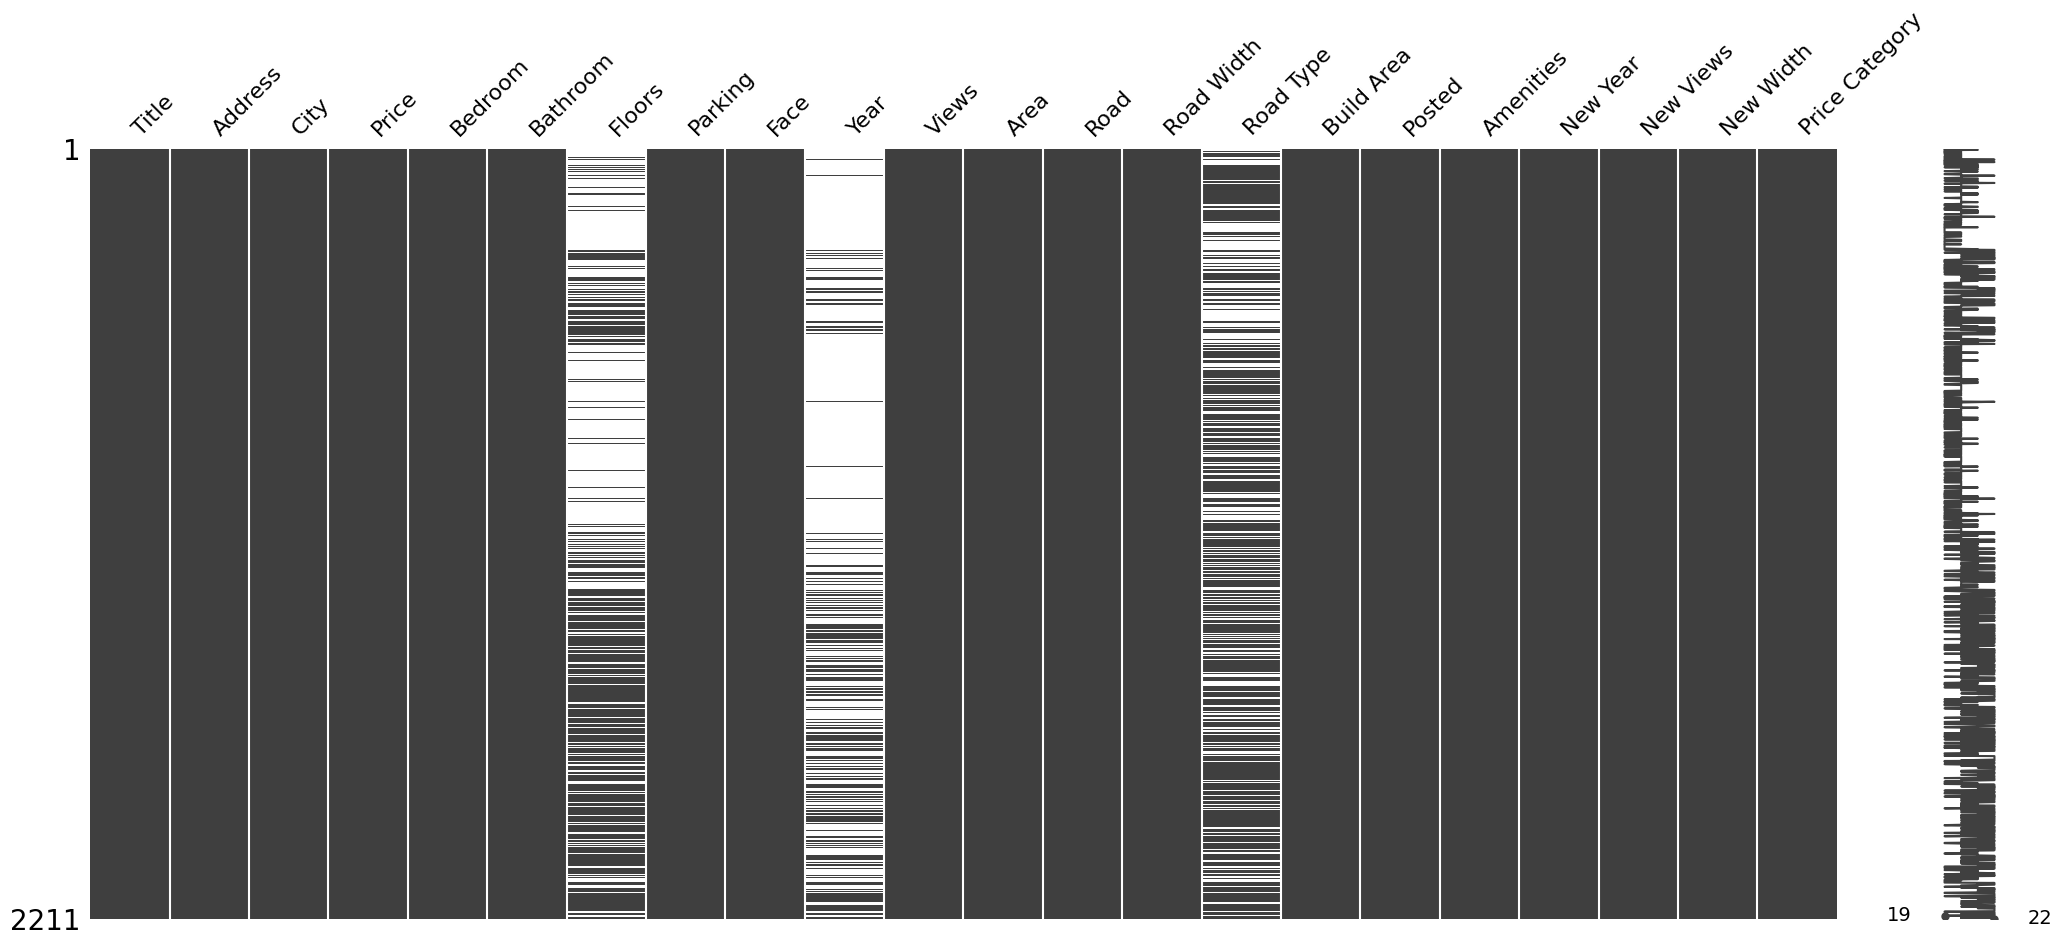

In [34]:
sorted_floor = data.sort_values(by = ['Price', 'Bedroom', 'Parking'])
msno.matrix(sorted_floor)
plt.show()

<Axes: >

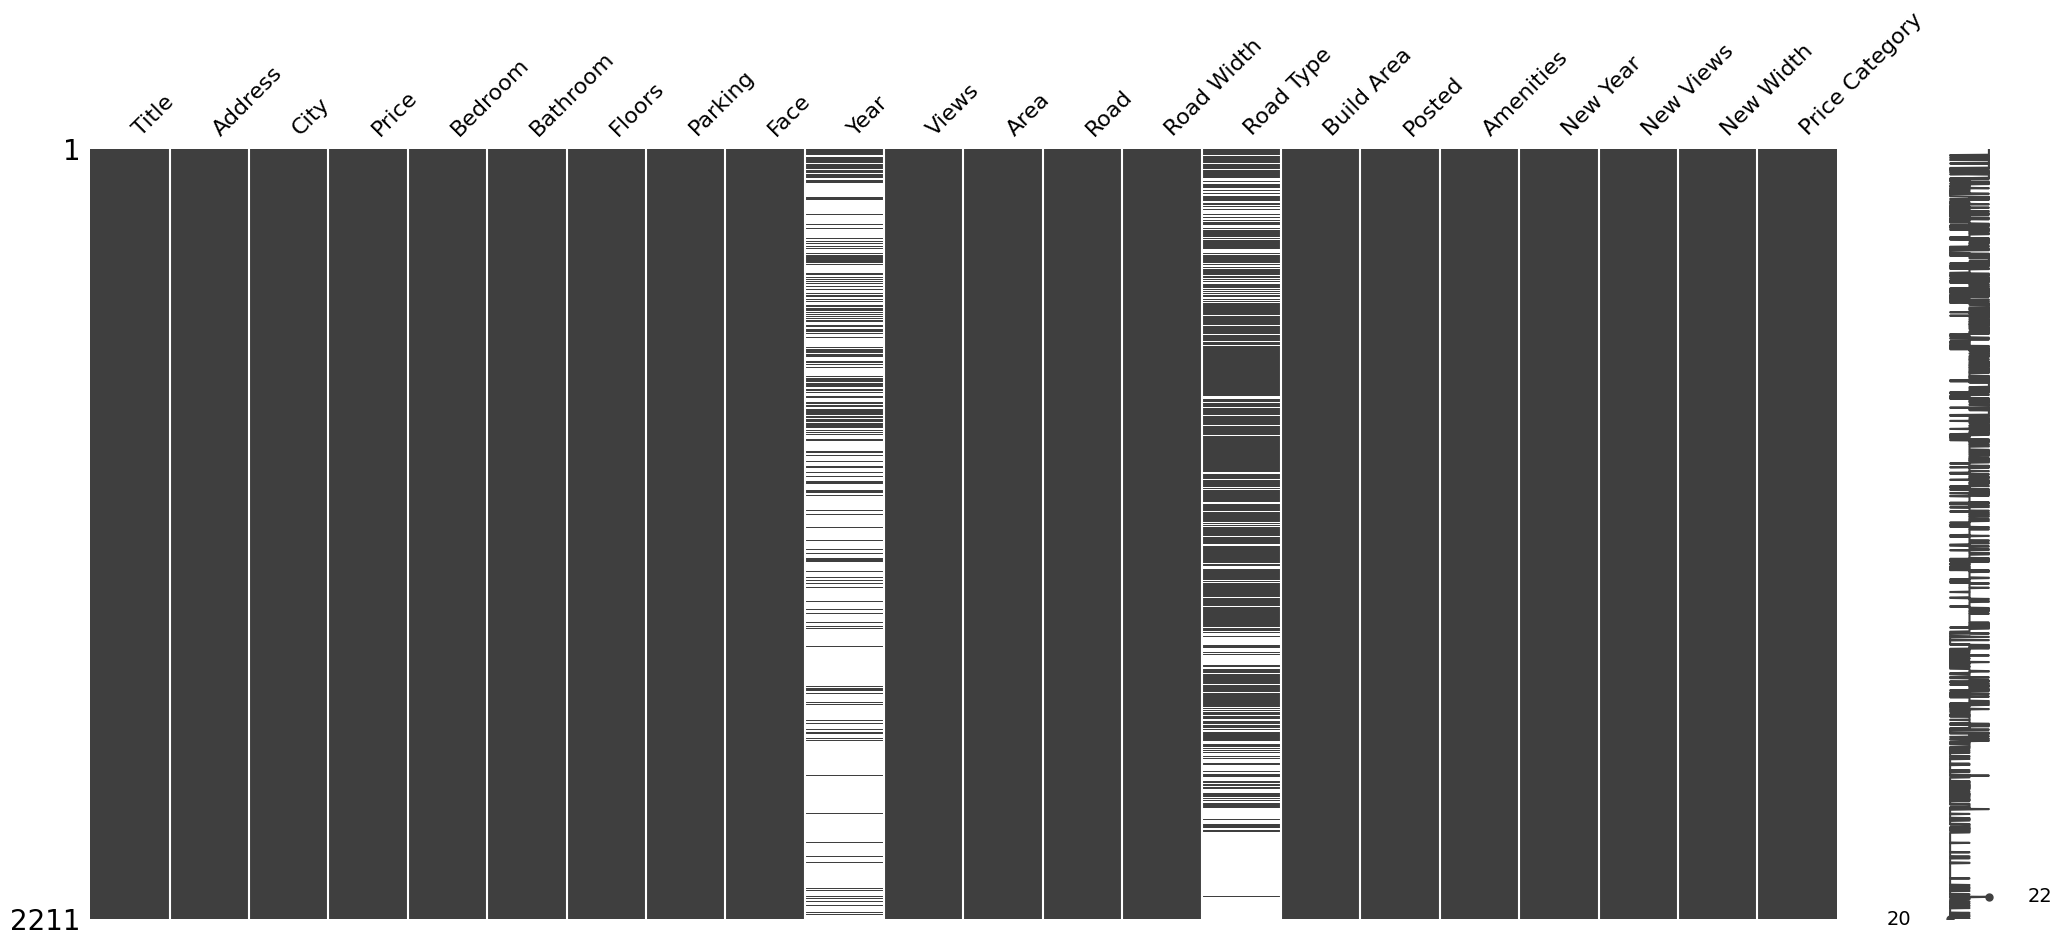

In [35]:
floor_mean = int(data['Floors'].mean())

data_imputed_floor = data.fillna({'Floors': floor_mean})

msno.matrix(data_imputed_floor)

In [36]:
print(data['New Year'].min())

mean_new_year = int(data['Year'].mean())
print(data[data['Year'].isna()])

0
                                                  Title  \
17    2.5 Storey House On Sale At Daura Dipo , Check...   
18    House For Sale At Kalanki : House For Sale In ...   
19    House Sale In Lolang Height : House For Sale I...   
21             House For Sale In Radhe Radhe, Bhaktapur   
25    Dhapasi Deurali Janata Najik Ghar : House For ...   
...                                                 ...   
2205         Land For Sale In Budhanilkantha, Kathmandu   
2206               House For Rent In Chapali, Kathmandu   
2207             House For Sale In Sitapaila, Kathmandu   
2209             House For Rent In Baneshwor, Kathmandu   
2210             House For Sale In Baluwatar, Kathmandu   

                                     Address       City     Price  Bedroom  \
17            Daura Dipo, Thankot, Kathmandu  Kathmandu  18500000        4   
18           khasibazaar, Kalanki, Kathmandu  Kathmandu  62000000        7   
19      Lonag height, Kavresthali, Kathmandu  Kathmandu

In [37]:
print(data_imputed_floor['Road Type'].value_counts())
data_imputed_incomplete = data_imputed_floor
data_imputed_floor['Road Type'].str.strip()

cols = ['Price', 'Year', 'Bathroom', 'Floors', 'Parking']

data_imputed_incomplete_groups = data_imputed_incomplete.groupby('Road Type')[cols].agg(np.mean)

print(data_imputed_incomplete_groups)
print(data_imputed_incomplete['Road Type'].value_counts(dropna=False))


Road Type
Blacktopped        749
Gravelled          404
Soil Stabilized    167
Paved               77
Concrete            25
Alley                4
Name: count, dtype: int64
                        Price         Year  Bathroom    Floors   Parking
Road Type                                                               
Alley            6.850000e+06  2025.333333  3.000000  3.000000  0.750000
Blacktopped      2.258698e+07  2056.989209  4.078772  2.490654  0.767690
Concrete         1.617708e+07  2069.076923  3.520000  2.380000  0.640000
Gravelled        1.544149e+07  2063.616352  3.663366  2.266955  0.556931
Paved            1.980455e+07  2048.093023  3.896104  2.662338  1.051948
Soil Stabilized  1.036647e+07  2054.857143  3.790419  2.011976  0.287425
Road Type
NaN                 785
 Blacktopped        749
 Gravelled          404
 Soil Stabilized    167
 Paved               77
 Concrete            25
 Alley                4
Name: count, dtype: int64


C:\Users\swoye\AppData\Local\Temp\ipykernel_13536\604239626.py:7: FutureWarning: The provided callable <function mean at 0x000001887707D800> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data_imputed_incomplete_groups = data_imputed_incomplete.groupby('Road Type')[cols].agg(np.mean)


In [38]:
data_imputed_incomplete.loc[
    (data_imputed_incomplete['Road Type'].isna()) & (data_imputed_incomplete['Year'] <= 2025), 
    'Road Type'
] = "Alley"


data_imputed_incomplete['Road Type'] = data_imputed_incomplete['Road Type'].str.strip()
print(data_imputed_incomplete['Road Type'].value_counts(dropna=False))

Road Type
NaN                766
Blacktopped        749
Gravelled          404
Soil Stabilized    167
Paved               77
Concrete            25
Alley               23
Name: count, dtype: int64


In [39]:
data_imputed_incomplete.loc[
    (data_imputed_incomplete['Road Type'].isna()) & (data_imputed_incomplete['Year'] > 2025) & (data_imputed_incomplete['Year'] <= 2050), 
    'Road Type'
] = "Paved"

print(data_imputed_incomplete['Road Type'].value_counts(dropna=False))

Road Type
NaN                765
Blacktopped        749
Gravelled          404
Soil Stabilized    167
Paved               78
Concrete            25
Alley               23
Name: count, dtype: int64


In [40]:
data_imputed_incomplete.loc[
    (data_imputed_incomplete['Road Type'].isna()) & (data_imputed_incomplete['Year'] > 2050) & (data_imputed_incomplete['Year'] <= 2060), 
    'Road Type'
] = "Blacktopped"

print(data_imputed_incomplete['Road Type'].value_counts(dropna=False))

Road Type
NaN                763
Blacktopped        751
Gravelled          404
Soil Stabilized    167
Paved               78
Concrete            25
Alley               23
Name: count, dtype: int64


In [41]:
data_imputed_incomplete.loc[
    (data_imputed_incomplete['Road Type'].isna()) & (data_imputed_incomplete['Year'] > 2060) & (data_imputed_incomplete['Year'] <= 2065), 
    'Road Type'
] = "Gravelled"

print(data_imputed_incomplete['Road Type'].value_counts(dropna=False))

Road Type
NaN                761
Blacktopped        751
Gravelled          406
Soil Stabilized    167
Paved               78
Concrete            25
Alley               23
Name: count, dtype: int64


In [43]:
data_imputed_incomplete.loc[
    (data_imputed_incomplete['Road Type'].isna()) & (data_imputed_incomplete['Year'] > 2065), 
    'Road Type'
] = "Concrete"

print(data_imputed_incomplete['Road Type'].value_counts(dropna=False))

Road Type
Blacktopped        751
NaN                727
Gravelled          406
Soil Stabilized    167
Paved               78
Concrete            59
Alley               23
Name: count, dtype: int64


In [44]:
data_imputed_incomplete.loc[
    (data_imputed_incomplete['Road Type'].isna()) & (data_imputed_incomplete['Parking'] >= 1), 
    'Road Type'
] = "Paved"

print(data_imputed_incomplete['Road Type'].value_counts(dropna=False))

Road Type
Blacktopped        751
NaN                514
Gravelled          406
Paved              291
Soil Stabilized    167
Concrete            59
Alley               23
Name: count, dtype: int64


In [45]:
data_imputed_incomplete.loc[
    (data_imputed_incomplete['Road Type'].isna()) & (data_imputed_incomplete['Parking'] <= 0.5), 
    'Road Type'
] = "Soil Stabilized"

print(data_imputed_incomplete['Road Type'].value_counts(dropna=False))
print(data_imputed_incomplete['Parking'].max())
cleanData = data_imputed_incomplete

Road Type
Blacktopped        751
Soil Stabilized    681
Gravelled          406
Paved              291
Concrete            59
Alley               23
Name: count, dtype: int64
2


<Axes: >

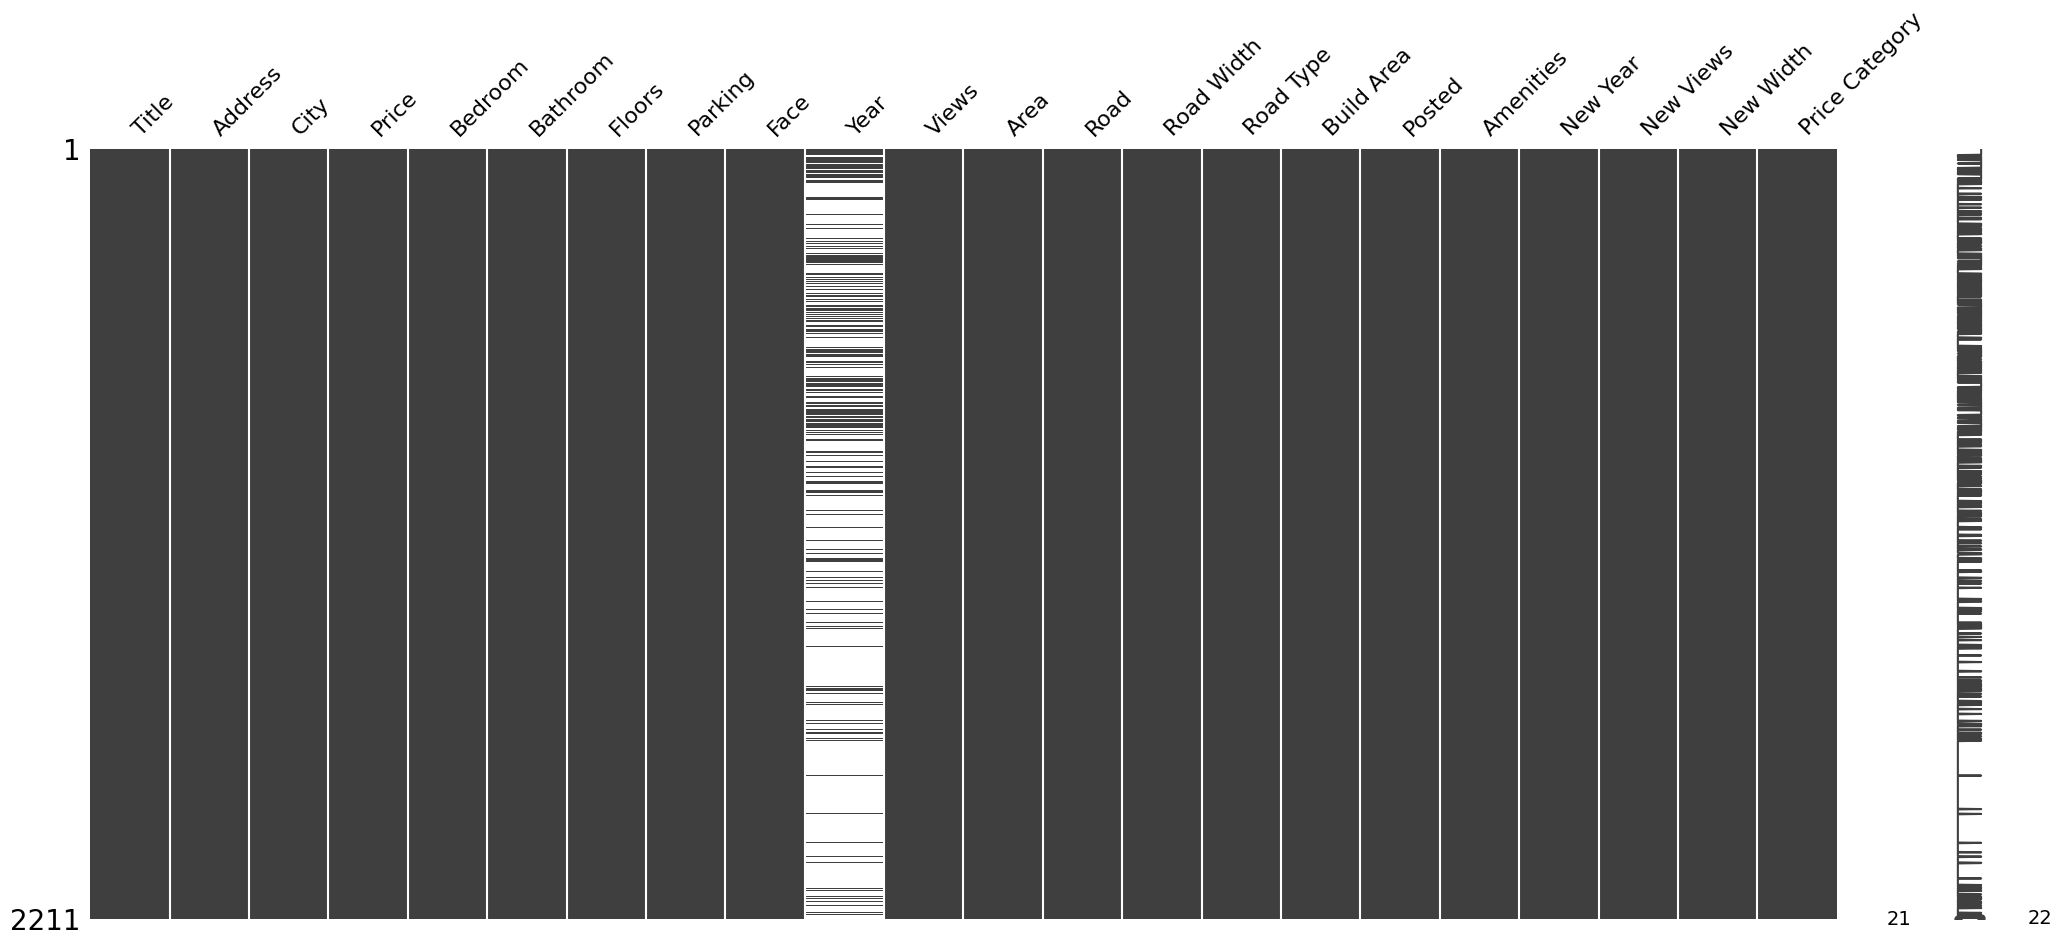

In [46]:
msno.matrix(data_imputed_incomplete)

In [47]:
first_ct = pd.crosstab(cleanData['City'], cleanData['Road Width'], margins=True)

print(first_ct)

Road Width   0 Feet  0 Feet   0 Meter   1 Feet  1 Feet   1 Meter   10 Feet  \
City                                                                         
Bara              0        1         0       0        0         0        0   
Bardiya           0        0         0       0        0         0        0   
Bhairahawa        0        0         0       0        0         0        0   
Bhaktapur         5        1         0       0        0         0        2   
Biratnagar        1        1         0       0        0         0        0   
Birtamod          0        0         0       0        0         0        0   
Butwal            1        0         0       0        0         0        0   
Chitwan           0        0         0       0        0         0        0   
Dang              1        0         0       0        0         0        0   
Dhading           0        0         0       0        0         0        0   
Dharan            0        0         1       0        0         

c:\Users\swoye\Documents\first_kaggle\venv\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\swoye\Documents\first_kaggle\venv\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


<Figure size 640x480 with 0 Axes>

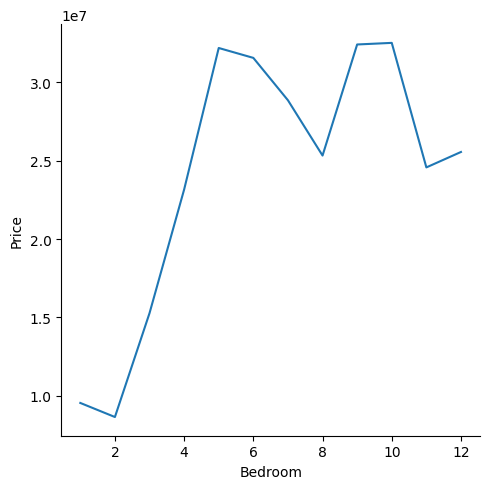

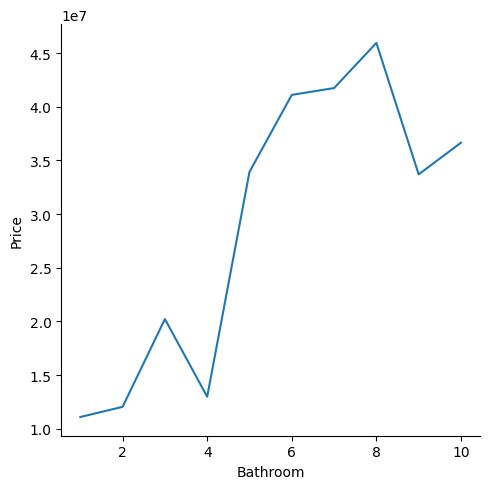

In [48]:
fig = plt.figure()
sns.relplot(x = 'Bedroom', y = 'Price', data = cleanData, ci = None, kind='line')
sns.relplot(x = 'Bathroom', y = 'Price', data = cleanData, ci = None, kind='line')

plt.show()

The city with the most houses available!!

In [59]:
popularCity = cleanData['City'].value_counts().index[0]

The highest priced house in each city!!

In [61]:
priceDf = cleanData.groupby('City')['Price'].max()

print(priceDf)

City
Bara            1300000
Bardiya         3650000
Bhairahawa     64300000
Bhaktapur      64300000
Biratnagar      8000000
Birtamod        1300000
Butwal         25000000
Chitwan        64300000
Dang            1300000
Dhading        62000000
Dharan         12500000
Illam           1850000
Itahari         1300000
Jhapa          20000000
Kailali         6700000
Kapilvastu     37000000
Kaski          64300000
Kathmandu      64300000
Kavre          15200000
Kirtipur       59000000
Lalitpur       64300000
Mahottari       1300000
Makwanpur      20000000
Morang          1300000
Nawalparasi     2200000
Nawalpur       11000000
Parsa           4500000
Pokhara        64300000
Rupandehi       1300000
Sunsari        15000000
Surkhet        20000000
Tanahu         15000000
Name: Price, dtype: int64


In [62]:
print(cleanData['Area'])

0        1-0-0-0 Aana
1       0-21-0-0 Aana
2        1-1-0-0 Aana
3       0-10-1-0 Aana
4       0-19-2-0 Aana
            ...      
2206         1 Ropani
2207         2.5 Aana
2208           8 Aana
2209          51 Aana
2210          13 Aana
Name: Area, Length: 2211, dtype: object


Maximum of various departments of house based on cities!!

In [64]:
maxDF = cleanData.groupby('City')[['Price', 'Bedroom', 'Bathroom', 'Floors', 'Parking']].max()

print(maxDF)

                Price  Bedroom  Bathroom  Floors  Parking
City                                                     
Bara          1300000        1         4     2.0        0
Bardiya       3650000        4         1     2.0        0
Bhairahawa   64300000       12        10     3.0        1
Bhaktapur    64300000       12         4     5.0        2
Biratnagar    8000000        3         4     2.0        1
Birtamod      1300000        1         4     2.0        0
Butwal       25000000       10         4     3.0        2
Chitwan      64300000       12         6     3.0        2
Dang          1300000        1         4     2.0        0
Dhading      62000000        4         4     2.0        0
Dharan       12500000        1         4     2.0        0
Illam         1850000        1         4     0.0        0
Itahari       1300000        1         4     2.0        0
Jhapa        20000000        4         4     4.0        2
Kailali       6700000        1         4     2.0        0
Kapilvastu   3

In [75]:
print(cleanData.columns)

Index(['Title', 'Address', 'City', 'Price', 'Bedroom', 'Bathroom', 'Floors',
       'Parking', 'Face', 'Year', 'Views', 'Area', 'Road', 'Road Width',
       'Road Type', 'Build Area', 'Posted', 'Amenities', 'New Year',
       'New Views', 'New Width', 'Price Category'],
      dtype='object')


In [78]:
cityXprice = pd.crosstab(cleanData['City'], cleanData['Price Category'])

print(cityXprice)

Price Category  High  Low  Medium
City                             
Bara               0    0       4
Bardiya            0    1       0
Bhairahawa         1    0       0
Bhaktapur         48    1      36
Biratnagar         1    0       5
Birtamod           0    0       1
Butwal             2    0       4
Chitwan           21    2      10
Dang               0    0       1
Dhading            3    0       1
Dharan             6    0       5
Illam              1    0       0
Itahari            0    0       3
Jhapa              5    0       5
Kailali            1    0       0
Kapilvastu         1    0       0
Kaski              1    0       2
Kathmandu       1051   15     417
Kavre              3    0       4
Kirtipur           6    0       1
Lalitpur         218    9     205
Mahottari          0    0       1
Makwanpur          4    0       8
Morang             0    0       4
Nawalparasi        3    0       9
Nawalpur           1    0       0
Parsa              2    0       2
Pokhara       

In [79]:
cityXroad = pd.crosstab(cleanData['City'], cleanData['Road Type'])

print(cityXroad)

Road Type    Alley  Blacktopped  Concrete  Gravelled  Paved  Soil Stabilized
City                                                                        
Bara             0            0         0          0      0                4
Bardiya          0            0         0          0      0                1
Bhairahawa       0            0         0          0      1                0
Bhaktapur        0           29         1         18      3               34
Biratnagar       0            2         0          3      0                1
Birtamod         0            0         0          0      0                1
Butwal           1            2         0          2      0                1
Chitwan          1           15         1          7      2                7
Dang             0            0         0          0      0                1
Dhading          0            0         0          1      0                3
Dharan           0            6         0          3      1                1